## Cats and Cookies
[Cookie Cats](https://www.facebook.com/cookiecatsgame) is a highly popular mobile puzzle game developed by [Tactile Entertainment](http://tactile.dk). It follows the classic "connect three" puzzle format, where players must link tiles of the same color to clear the board and advance to the next level. Adding to the fun, the game features singing cats—yes, you heard that right! Take a look at this brief demo:

[![Cookie Cats Video](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg)](https://youtu.be/GaP5f0jVTWE)

As players move through the game’s levels, they occasionally encounter gates that either require them to wait a significant amount of time or make an in-app purchase to continue. While these gates encourage in-app purchases, they also serve an essential function by giving players a forced break. This pause can potentially enhance and prolong their enjoyment of the game.

![Cookie Cats Gates](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png)

The question is: where should these gates be placed? Initially, the first gate was set at level 30, but in this analysis, we’ll examine an A/B test where the first gate was shifted from level 30 to level 40. Our focus will be on assessing its impact on player retention. Before diving into the analysis, though, it's crucial to familiarize ourselves with the data. Let’s load it and take a closer look!



In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-Test Data
The dataset consists of information from 90,189 players who installed the game during the AB-test period. The variables are as follows:

- **`userid`**: A unique identifier for each player.
- **`version`**: Indicates whether the player was assigned to the control group (`gate_30`, with a gate at level 30) or the experimental group (`gate_40`, with a gate at level 40).
- **`sum_gamerounds`**: The total number of game rounds played by the player in the first 14 days after installation.
- **`retention_1`**: A binary value indicating whether the player returned to play **1 day** after installation.
- **`retention_7`**: A binary value indicating whether the player returned to play **7 days** after installation.

Players were randomly assigned to either the `gate_30` or `gate_40` group upon installing the game. As a quick sanity check, let's verify if both AB groups have roughly the same number of players.


In [2]:
# Counting the number of players in each AB group.
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

## 3. The Distribution of Game Rounds

![Mr. Waffles Smiling](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png)

It seems we have a fairly even distribution of players across both groups, which is great!

While our main focus is to analyze how gate placement impacts player retention, let’s take a moment for something fun. We'll plot the distribution of the number of game rounds played by players during their first week of gameplay.


In [3]:
plot_df = df.groupby('sum_gamerounds').count().reset_index()
plot_df.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


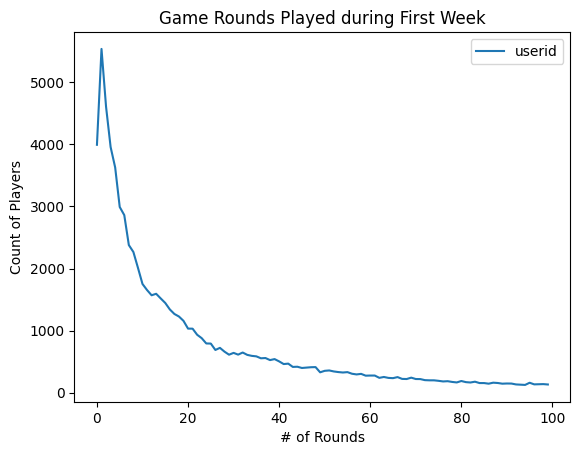

In [15]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds').count().reset_index()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("# of Rounds")
ax.set_ylabel("Count of Players")
ax.set_title("Game Rounds Played during First Week");

## 4. Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>As a first step, let's look at what 1-day retention is overall.</p>

In [16]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

## 5. 1-Day Retention by AB Group

![Belle Cookie](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png)

It appears that just under half of the players return to the game one day after installing it. Now that we have this baseline, let’s examine how 1-day retention compares between the two AB groups.


In [17]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. Should we be confident in the difference?
<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?</p>
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

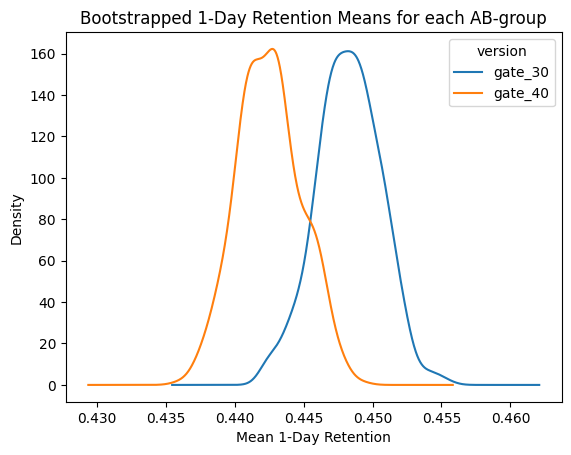

In [18]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1d.plot.kde()
ax.set_title('Bootstrapped 1-Day Retention Means for each AB-group')
ax.set_xlabel('Mean 1-Day Retention');

## 7. Zooming in on the difference
<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>
<p>(<em>Note that in this notebook we have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10 000.</em>)</p>

In [19]:
# checking first few rows of boot_1d 
boot_1d.head()

version,gate_30,gate_40
retention_1,0.447980,0.443709
retention_1,0.448468,0.443076
retention_1,0.451006,0.442424
retention_1,0.448871,0.442817
retention_1,0.450532,0.443406


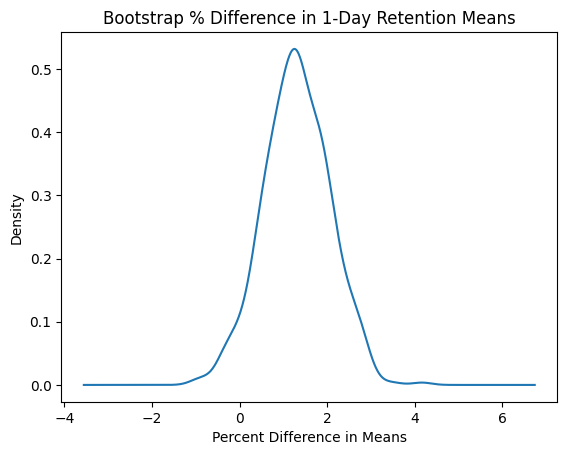

In [20]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)
                   / boot_1d.gate_40 * 100)

# Plotting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Percent Difference in Means')
ax.set_title('Bootstrap % Difference in 1-Day Retention Means');

## 8. The probability of a difference
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [21]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])
# or prob = (boot_1d['diff'] > 0).mean()

# Pretty printing the probability
'{0:.1%}'.format(prob)

'95.6%'

## 9. 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Let's start by calculating 7-day retention for the two AB-groups.</p>

In [22]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'100.0%'

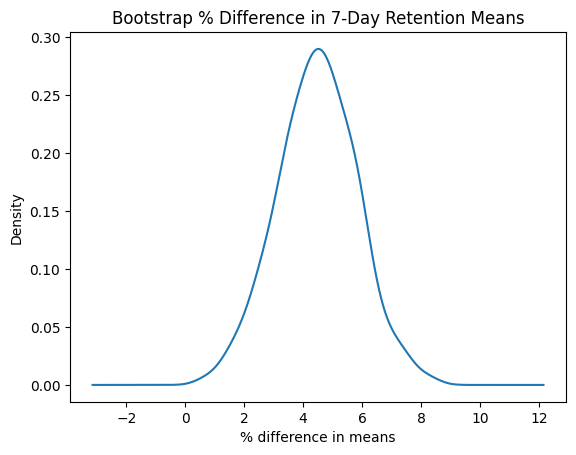

In [23]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title('Bootstrap % Difference in 7-Day Retention Means');

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()

# Pretty printing the probability
'{0:.1%}'.format(prob)

## 11. The Conclusion

The bootstrap analysis reveals strong evidence that 7-day retention is higher when the gate is placed at level 30 compared to level 40. The takeaway is clear: if we aim to maintain high retention — both 1-day and 7-day — we should **not** move the gate from level 30 to level 40. 

While there are other metrics we could consider, such as the number of game rounds played or in-game purchases made by the two AB groups, retention remains one of the most critical metrics. After all, if we fail to retain our players, how much they spend in-game becomes irrelevant.

![Yellow Cookie](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png)

But why is retention higher when the gate is placed earlier? One might expect the opposite: the later the obstacle, the longer players would engage with the game. However, the data tells a different story. The concept of **hedonic adaptation** offers a potential explanation. In essence, hedonic adaptation refers to the tendency for people to derive less enjoyment from a fun activity over time if it is done continuously. By introducing a forced break with the gate, players' enjoyment of the game is extended. When the gate is moved to level 40, fewer players reach that point, leading them to quit the game out of boredom.


In [25]:
# So, given the data and the bootstrap analysis
# Should we move the gate from level 30 to level 40 ?
move_to_level_40 = False